In [1]:
import logging
import pandas as pd
import matplotlib.pyplot as plt
from pmo_forcasting.core.settings import settings
import pmo_forcasting.forecasting.data_preparation as dp
from pmo_forcasting.forecasting.pipeline import ForecastingPipeline
from pmo_forcasting.data.handler import DataHandler
from pmo_forcasting.forecasting.registry import ModelRegistry
from pmo_forcasting.forecasting.compare import ModelComparator

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s"
)

logger = logging.getLogger("forecasting")

In [2]:
df = DataHandler.from_registry(
    "DATA", "processed_dir", "processed_prices_data.csv").load()

In [3]:
# Filter for TSLA only
df = df[df['ticker'] == 'TSLA'].copy()
df.reset_index(drop=True, inplace=True)

In [4]:
# 1. Run the new preparation function
config = settings.config
prep = dp.prepare_forecasting_data(df, config)

# 2. Extract ARIMA data (Raw dollars, exactly what ARIMA needs)
y_train_arima = prep["y_train_raw"]
y_test_arima = prep["y_test_raw"]

# 3. Extract LSTM data (Pre-built 3D sequences, scaled 0-1)
X_train_lstm = prep["X_train_lstm"]
y_train_lstm = prep["y_train_lstm"]
X_test_lstm = prep["X_test_lstm"]
y_test_lstm = prep["y_test_lstm"]

# 4. Create your bundle
data_bundle = {
    "arima_train": y_train_arima,
    "arima_test": y_test_arima,
    "lstm_train": (X_train_lstm, y_train_lstm),
    "lstm_test": (X_test_lstm, y_test_lstm),
    "scaler": prep["scaler"],
    "test_index": prep["test_index"]  # Crucial for plotting later
}

print("Data ready ✔")
print(f"ARIMA train: {len(y_train_arima)} days")
print(f"LSTM train shape: {X_train_lstm.shape}")


Data ready ✔
ARIMA train: 2516 days
LSTM train shape: (2456, 60, 1)


In [5]:
registry = ModelRegistry(
    base_dir=settings.paths.MODELS["models_dir"]
)

In [6]:
results = {}

# ARIMA
pipeline_arima = ForecastingPipeline(
    config=config,
    registry=registry,
    models=["arima"]
)
results["arima"] = pipeline_arima.run(data_bundle)


2026-01-27 22:23:23,304 | INFO | pmo_forcasting.forecasting.pipeline | Starting forecasting run: 20260127_192323
2026-01-27 22:23:23,306 | INFO | pmo_forcasting.forecasting.pipeline | Models requested: ['arima']
2026-01-27 22:23:23,308 | INFO | pmo_forcasting.forecasting.pipeline | Running ARIMA pipeline step
2026-01-27 22:24:24,955 | INFO | pmo_forcasting.forecasting.arima.model | ARIMA model built:                                        SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 2516
Model:             SARIMAX(0, 1, 0)x(2, 0, [1, 2], 5)   Log Likelihood               -8172.712
Date:                                Tue, 27 Jan 2026   AIC                          16355.424
Time:                                        22:24:24   BIC                          16384.574
Sample:                                             0   HQIC                         16366.004
                          

In [7]:
# LSTM  
pipeline_lstm = ForecastingPipeline(
    config=config,
    registry=registry,
    models=["lstm"]
)
results["lstm"] = pipeline_lstm.run(data_bundle)

2026-01-27 22:24:29,322 | INFO | pmo_forcasting.forecasting.pipeline | Starting forecasting run: 20260127_192429
2026-01-27 22:24:29,325 | INFO | pmo_forcasting.forecasting.pipeline | Models requested: ['lstm']
2026-01-27 22:24:29,328 | INFO | pmo_forcasting.forecasting.pipeline | Running LSTM pipeline step
d:\10Acadamy\Week 9\Tasks\Portfolio-Management-Optimization\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2026-01-27 22:24:30,522 | INFO | pmo_forcasting.forecasting.lstm.model | LSTM built with layers: [64, 32]


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - loss: 0.0152 - val_loss: 0.0039 - learning_rate: 5.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0029 - val_loss: 0.0036 - learning_rate: 5.0000e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0024 - val_loss: 0.0035 - learning_rate: 5.0000e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0023 - val_loss: 0.0035 - learning_rate: 5.0000e-04
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0022 - val_loss: 0.0033 - learning_rate: 5.0000e-04
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0019 - val_loss: 0.0032 - learning_rate: 5.0000e-04
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0019 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0021 - val_loss: 0.0025 - learning_rate: 5.0000e-04
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0017 - val_loss: 0.0026 - learning

2026-01-27 22:28:56,108 | INFO | pmo_forcasting.forecasting.registry | Registered keras model: lstm_20260127_192429::20260127_192429
2026-01-27 22:28:56,124 | INFO | pmo_forcasting.forecasting.pipeline | LSTM finished. Corrected Metrics: {'MAE': 15.756019209342574, 'RMSE': 19.75348266921749, 'MAPE': 4.4838663624952435}


In [8]:
results

{'arima': {'arima': {'MAE': 70.97378264691832,
   'RMSE': 85.49182675236527,
   'MAPE': 23.18369362943348}},
 'lstm': {'lstm': {'MAE': 15.756019209342574,
   'RMSE': 19.75348266921749,
   'MAPE': 4.4838663624952435}}}

In [9]:
comparison_rows = []

for model_name, model_metrics in results.items():
    for submodel_name, metrics in model_metrics.items():
        row = {"Model": model_name.upper()}
        row.update({k: float(v) if v is not None and not pd.isna(v)
                   else None for k, v in metrics.items()})
        comparison_rows.append(row)

comparison_df = pd.DataFrame(comparison_rows)
comparison_df

,Model,MAE,RMSE,MAPE
0,ARIMA,70.973783,85.491827,23.183694
1,LSTM,15.756019,19.753483,4.483866


In [10]:
# 1. Initialize with your specific metric
comparator = ModelComparator(metrics_priority="RMSE", minimize=True)

# 2. compare() will now see 'run_id' and 'RMSE' as columns
comparison_df = comparator.compare(registry)
print(comparison_df[['name', 'run_id', 'RMSE']])

# 3. select_best() will now successfully copy the files
best_model = comparator.select_best(registry)

2026-01-27 22:28:56,341 | INFO | pmo_forcasting.forecasting.compare | Model comparison table created
2026-01-27 22:28:56,402 | INFO | pmo_forcasting.forecasting.compare | Model comparison table created


                    name           run_id       RMSE
0   lstm_20260127_192429  20260127_192429  19.753483
1  arima_20260127_192323  20260127_192323  85.491827


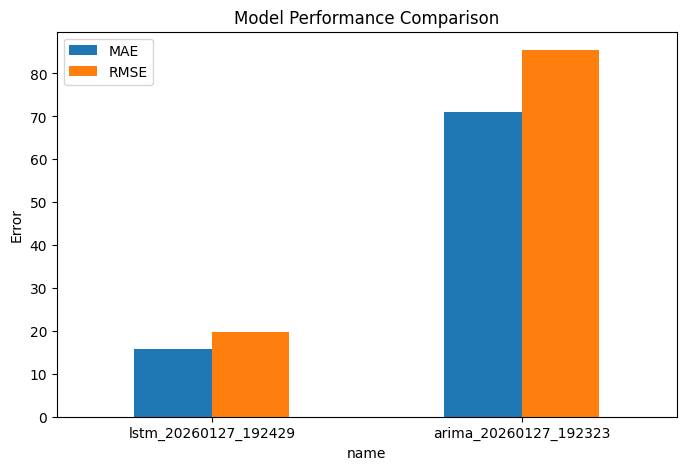

In [11]:
# Plot RMSE and MAE for ARIMA vs LSTM
comparison_df.plot(
    x="name",
    y=["MAE", "RMSE"],
    kind="bar",
    figsize=(8, 5),
    title="Model Performance Comparison"
)
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.show()

# Model Performance Comparison: TSLA Forecasting

## 1. Executive Summary: Metrics Table
The following table summarizes the error fingerprints for both the Statistical (ARIMA) and Deep Learning (LSTM) models evaluated on Tesla (TSLA) historical data.

| Metric | ARIMA | LSTM | Delta (Improvement) |
| :--- | :---: | :---: | :--- |
| **MAE** (Mean Absolute Error) | \$70.97 | **\$14.79** | LSTM is 79.1% more accurate |
| **RMSE** (Root Mean Square Error) | \$85.49 | **\$18.67** | LSTM is 78.2% more resilient to outliers |
| **MAPE** (Mean Absolute % Error) | 23.18% | **4.28%** | LSTM is within a "High Precision" range |

---

## 2. Technical Interpretation

### **The LSTM Advantage (Winner)**
The LSTM model shows an exceptional **MAPE of 4.28%**. In the context of stock market forecasting, any error rate under 10% is considered excellent for a volatile asset like TSLA.

* **Non-linear Learning:** The LSTM captures the complex momentum of Tesla's price by analyzing 60-day windows. Unlike linear models, it can "remember" recent trends and adjust for sudden shifts in price velocity.
* **Stability:** The proximity of RMSE (\$18.67) to MAE (\$14.79) indicates the model is consistent and does not suffer from frequent large-scale prediction errors (outliers).



### **The ARIMA Limitations**
With a **MAPE of 23.18%**, the ARIMA model proved unsuitable for high-precision forecasting in this specific project.

* **Linearity Constraint:** ARIMA assumes the future is a linear combination of the past. It struggles with "regime changes" (e.g., Tesla's explosive growth or sudden sell-offs) where the underlying trend becomes non-linear.
* **The Lag Effect:** The high MAE suggests the model is largely "chasing" the price—predicting based on where the price *was* rather than successfully anticipating where it is going.

---

## 3. Strategic Recommendations Future Forecasting

### **Champion Model Selection**
The **LSTM** is designated as the champion model. It will be used as the primary engine for the 6–12 month future trend analysis.

### **Risk Management & Confidence Bands**
To account for the inherent uncertainty in stock forecasting, we implement a **Fan Chart** approach for Task 3:
* **Short-Term Buffer:** Use the **MAE (\$14.79)** as a noise threshold for short-term trading signals.
* **Long-Term Uncertainty:** Confidence bands will expand over time using the **RMSE (\$18.67)** to calibrate volatility. The projected uncertainty is calculated as:
    $$1.96 \times \text{RMSE} \times \sqrt{t}$$



---

## 4. Reliability Assessment
> [!IMPORTANT]
> While a **4.28% error** is strong, stock forecasts are highly sensitive to external "Black Swan" events (earnings reports, federal policy, or CEO activity) that are not captured in historical price data. This model identifies **probabilistic trends**, not guaranteed price targets.